# Twitter Data Analysis - User Post Breakdown

This notebook analyzes the tweet distribution across users in our SQLite database.

In [1]:
!pip3 install matplotlib
!pip3 install seaborn

You should consider upgrading via the '/Users/marcus/Desktop/code/misc/twitter-scraper/venv/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/marcus/Desktop/code/misc/twitter-scraper/venv/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
DB_FILE = "tweets.db"
conn = sqlite3.connect(DB_FILE)

user_df = pd.read_sql_query(
    "SELECT DISTINCT author_id, username FROM pagination_state",
    conn
)

## Overall Tweet Distribution

In [4]:
tweet_counts = pd.read_sql_query("""
    SELECT
        t.author_id,
        p.username,
        COUNT(*) as total_tweets,
        SUM(CASE WHEN is_reply = 1 THEN 1 ELSE 0 END) as replies,
        SUM(CASE WHEN is_reply = 0 THEN 1 ELSE 0 END) as original_tweets
    FROM tweets t
    LEFT JOIN pagination_state p ON t.author_id = p.author_id
    GROUP BY t.author_id, p.username
""", conn)

print("Tweet Distribution by User:")
display(tweet_counts)

Tweet Distribution by User:


,author_id,username,total_tweets,replies,original_tweets
0,100831103,None,1,1,0
1,101981655,None,1,1,0
2,1033980855755071488,None,1,1,0
3,1040138864172646400,None,1,1,0
4,1051536801217867776,None,1,1,0
...,...,...,...,...,...
670,977893052688879616,None,1,1,0
671,989152642294202368,None,2,2,0
672,991219307777376257,None,1,1,0
673,99139630,None,1,1,0


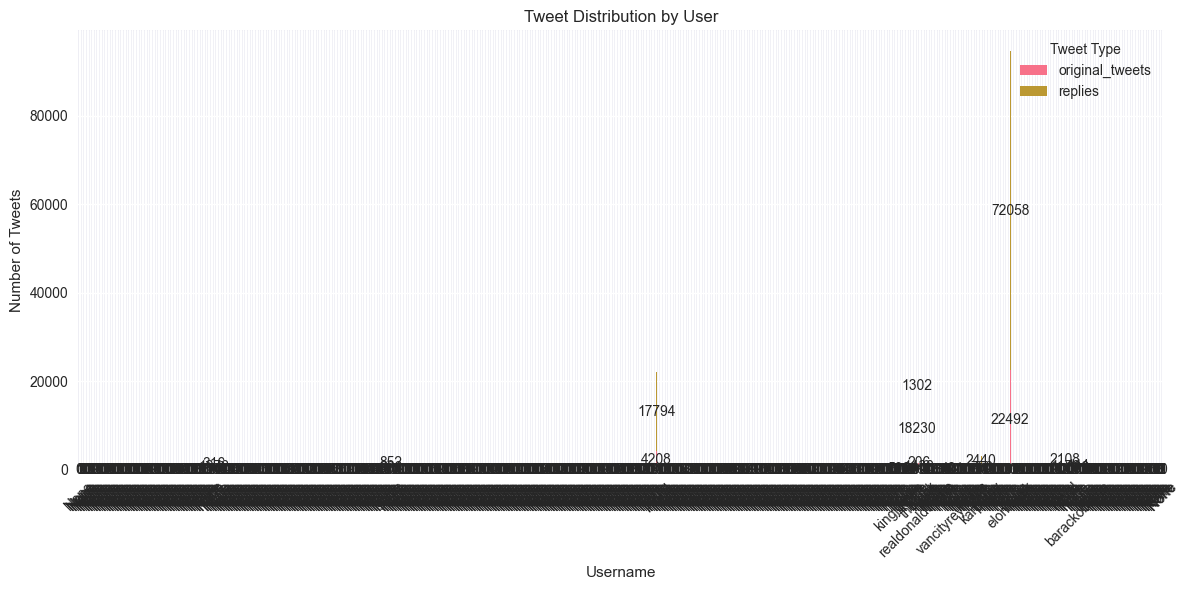

In [5]:
ax = tweet_counts.plot(x='username', y=['original_tweets', 'replies'],
                      kind='bar', stacked=True, figsize=(12, 6))

plt.title('Tweet Distribution by User')
plt.xlabel('Username')
plt.ylabel('Number of Tweets')
plt.legend(title='Tweet Type')
plt.xticks(rotation=45)

for c in ax.containers:
    ax.bar_label(c, label_type='center')

plt.tight_layout()
plt.show()

## Engagement Analysis

In [6]:
# Get engagement metrics by user
engagement_df = pd.read_sql_query("""
    SELECT
        p.username,
        AVG(like_count) as avg_likes,
        AVG(reply_count) as avg_replies,
        AVG(retweet_count) as avg_retweets,
        AVG(quote_count) as avg_quotes
    FROM tweets t
    LEFT JOIN pagination_state p ON t.author_id = p.author_id
    GROUP BY p.username
""", conn)

print("Average Engagement Metrics by User:")
display(engagement_df.round(2))

Average Engagement Metrics by User:


,username,avg_likes,avg_replies,avg_retweets,avg_quotes
0,None,0.67,0.15,0.03,0.00
1,aoc,32497.72,4715.06,4043.34,458.23
2,barackobama,125926.38,9057.61,13403.35,1291.62
3,elonmusk,42727.60,2295.65,5637.74,421.49
4,karpathy,1408.50,55.66,126.93,23.74
5,kingjames,45504.81,1282.37,3724.30,771.89
6,naval,3430.63,106.12,366.78,35.70
7,paulg,638.63,38.05,46.38,9.95
8,realdonaldtrump,12245.17,704.97,1927.15,136.47
9,sama,7320.84,554.66,545.81,216.80


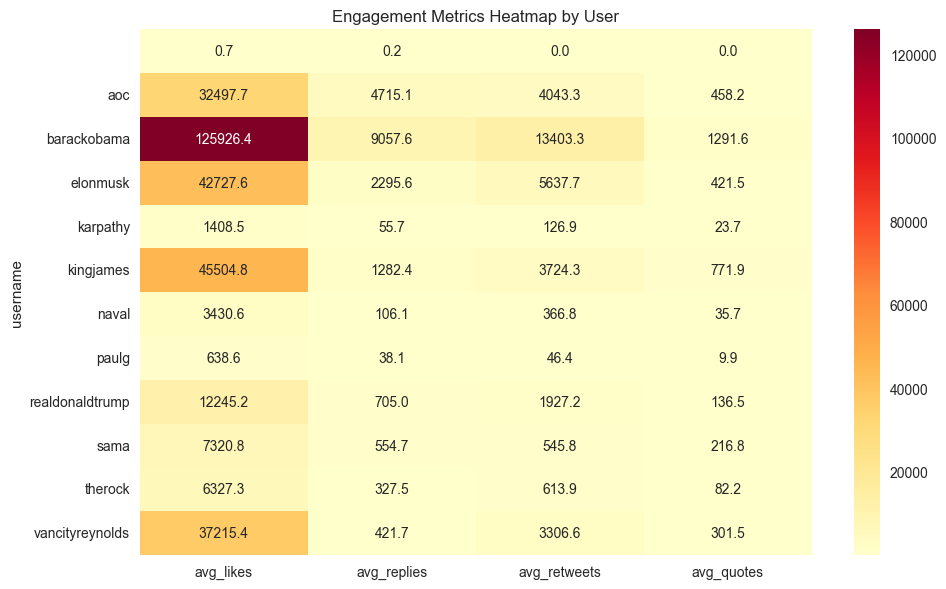

In [7]:
plt.figure(figsize=(10, 6))
sns.heatmap(engagement_df.set_index('username'), annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('Engagement Metrics Heatmap by User')
plt.tight_layout()
plt.show()

## Temporal Analysis

/var/folders/d7/k3bwymtd7bv6pljy94341_8m0000gn/T/ipykernel_90195/2572950305.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data['tweet_count'] = user_data['tweet_count'].clip(upper=200)
/var/folders/d7/k3bwymtd7bv6pljy94341_8m0000gn/T/ipykernel_90195/2572950305.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data['tweet_count'] = user_data['tweet_count'].clip(upper=200)
/var/folders/d7/k3bwymtd7bv6pljy94341_8m0000gn/T/ipykernel_90195/2572950305.py:21: SettingWithCopyWarning: 
A value is

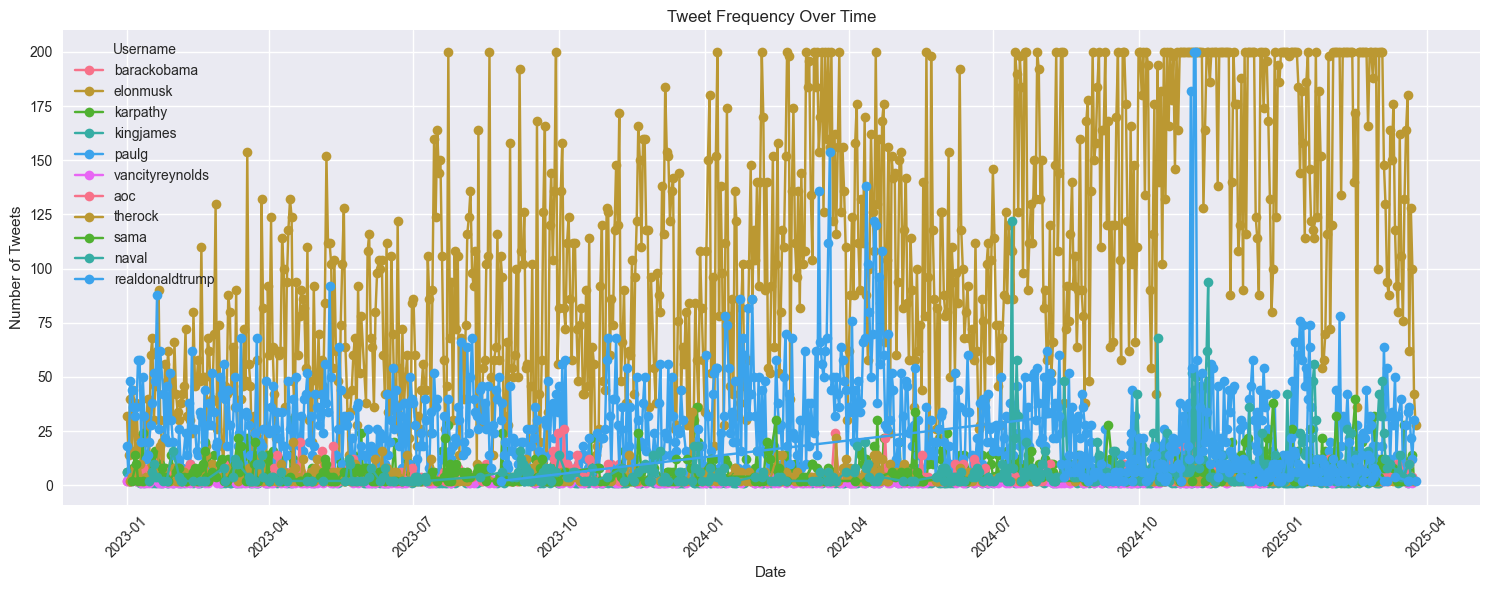

In [ ]:
# Get tweet counts over time
time_df = pd.read_sql_query("""
    SELECT
        date(created_at) as tweet_date,
        p.username,
        COUNT(*) as tweet_count
    FROM tweets t
    LEFT JOIN pagination_state p ON t.author_id = p.author_id
    GROUP BY date(created_at), p.username
    ORDER BY tweet_date
""", conn)

time_df['tweet_date'] = pd.to_datetime(time_df['tweet_date'])

plt.figure(figsize=(15, 6))
for username in time_df['username'].unique():
    user_data = time_df[time_df['username'] == username]
    # because some people tweet a lot on some days...
    user_data['tweet_count'] = user_data['tweet_count'].clip(upper=200)
    plt.plot(user_data['tweet_date'], user_data['tweet_count'], label=username, marker='o')

plt.title('Tweet Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.legend(title='Username')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
total_tweets = pd.read_sql_query("SELECT COUNT(*) FROM tweets", conn)
print(f"Total number of tweets: {total_tweets.iloc[0, 0]}")


Total number of tweets: 76107


In [10]:
conn.close()